### How to perform **`furry-couscous`** analysis
C. Heiser, October 2019

In [1]:
from fcc_utils import * # contains functions necessary for distance preservation analysis

`anndata` objects can be read straight from a file, or generated from an existing pandas dataframe or numpy array.  
These files can be comma- or tab-delimited, and compressed with `.zip` or `.gz`.  
Here, we will read in a file from [Macosko, _et al._ (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26000488), which has cell and gene labels, and is in a cells-by-genes format.

In [2]:
retina = sc.read_text('inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz', delimiter='\t')

These objects have a bunch of useful attributes, and it's easy to calculate some QC metrics and preprocess the raw counts:

In [3]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 20478 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

We can use `sc.pp.highly_variable_genes` to filter our dataset for HVGs.  
Here, we will manually select genes by brute-force variance for simplicity:

In [4]:
retina.var['variance'] = retina.layers['raw_counts'].var(axis=0) # add gene variance as .var metadata
retina = retina[:,retina.var['variance'].nlargest(500).index] # keep top 500 variable genes

In [5]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=100)

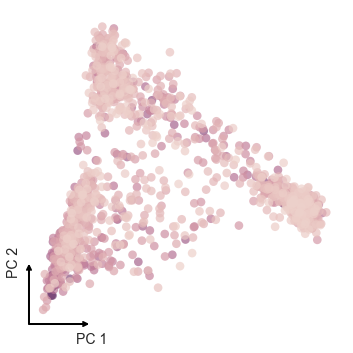

In [6]:
DR_plot(dim_name='PC').plot(retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'])

Now we can perform our favorite low-dimensional embedding on the arcsinh-transformed data...

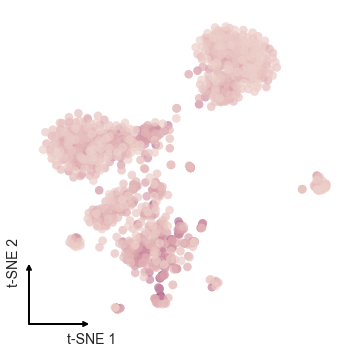

In [7]:
sc.tl.tsne(retina, use_rep='X')
DR_plot(dim_name='t-SNE').plot(retina.obsm['X_tsne'], color=retina.obs['log1p_total_counts'])

Or on the output of the PCA we performed:

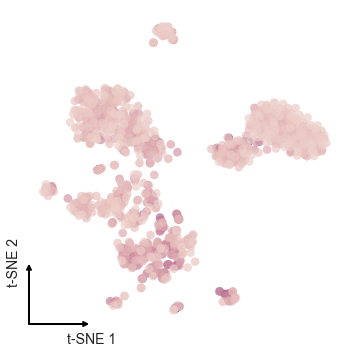

In [9]:
sc.tl.tsne(retina, use_rep='X_pca')
retina.obsm['pca_tsne'] = retina.obsm['X_tsne'].copy()
DR_plot(dim_name='t-SNE').plot(retina.obsm['pca_tsne'], color=retina.obs['log1p_total_counts'])

We can easily apply the `scipy.stats.distance_matrix()` function to different parts of our `AnnData` objects.

In [10]:
k = 30 # define k for knn calculation

In [11]:
# save distance matrix in AnnData object for easy access
retina.uns['pca_distance'] = cdist(retina.obsm['X_pca'], retina.obsm['X_pca'])
retina.uns['tsne_distance'] = cdist(retina.obsm['pca_tsne'], retina.obsm['pca_tsne'])

# calculate simple binary knn graph from the distance matrix above
knn_graph(retina.uns['pca_distance'], k, retina, save_rep='pca_knn')
knn_graph(retina.uns['tsne_distance'], k, retina, save_rep='tsne_knn')

In [12]:
%%time
pca_dist, tsne_dist, corr_stats, EMD = distance_stats(pre=retina.uns['pca_distance'], post=retina.uns['tsne_distance'])
knn = knn_preservation(pre=retina.uns['pca_knn'], post=retina.uns['tsne_knn'])
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr_stats[0],4), round(EMD,4), round(knn, 4)))

R: 0.7501
EMD: 0.2151
Knn Pres.: 97.2127
CPU times: user 950 ms, sys: 100 ms, total: 1.05 s
Wall time: 629 ms


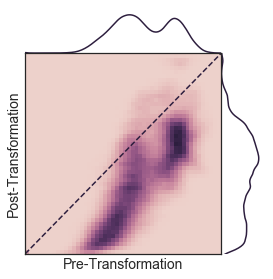

In [13]:
joint_plot_distance_correlation(pca_dist, tsne_dist)

Looks like a pretty good correlation between t-SNE and PCA spaces (R = 0.75).  
You can also look at the z-score normalized cumulative distance distributions in each projection and calculate the Wasserstein or Earth Mover's Distance between the two.

EMD: 0.2151


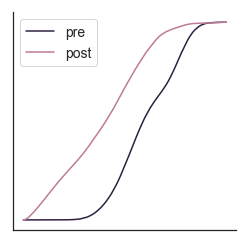

In [14]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_norm=pca_dist, post_norm=tsne_dist)
print('EMD: {}'.format(round(EMD,4)))